# Topic modeling on abstracts

## 1. Preprocessing

In [5]:
import pandas as pd
import os 
import numpy as np
import re
import random

In [6]:
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [7]:
#!pip install gensim

In [8]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### 1.1 Load the data 

In [9]:
#abstracts = pd.read_csv("abstracts.csv")
abstracts = pd.read_csv("abstracts_eng.csv")

In [10]:
abstracts.head()

,abstract,id
0,The goal of this note is to introduce new clas...,188444.0
1,We will review a Lemma published by Ran Raz in...,188623.0
2,China’s growing influence in Europe has the po...,346708.0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0
4,Passenger transit modes typical of the urban s...,187461.0


In [11]:
abs_list = list(abstracts['abstract'])

In [12]:
len(abs_list)

20494

**21421** abstracts in total  
**20494** abstracts in english

### 1.2 Step 1 
- tokenization 
- punctuation removal 
- lowercasing

In [13]:
tokenised = []
count = 0
for abstract in abs_list:
    raw = abstract
    tokens = gensim.utils.simple_preprocess(str(raw), deacc=True)
    tokenised.append(tokens)
    count += len(tokens)
print(str(count)+" tokens created")

3855522 tokens created


In [14]:
c = []
for doc in tokenised: 
    c+=doc
len(set(c))

71429

So we have **83831** / **71429** (de/en) unique words in the beginning

### 1.3 Step 2 
- removing stopwords 
- (removing other words based on different strategies - like word length thresholding) 

In [15]:
stop_words = stopwords.words('english')
cleaned = [[word for word in doc if word not in stop_words] for doc in tokenised]

In [16]:
# Consider extending the stopwords ...
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
# Consider removing words with less than [x] characters 

In [18]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

71293

Now after stopwords removal we have **83695** / **71293** terms (136 less)

### 1.4 Step 3 
- stemming 
- lemmatizing 

In [19]:
#nltk.download('wordnet')

In [20]:
word_stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
lemmatized = [[lemmatiser.lemmatize(word_stemmer.stem(word)) for word in doc] for doc in cleaned]

In [21]:
c = []
for doc in lemmatized: 
    c+=doc
len(set(c))

50948

And after stemming and lemmatization we have **61182** / **50948** terms (22,513 less)

Maybe we could also lemmatise keeping only noun, adjective, verb, adverb

data_lemmatized = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Daniel: slightly different approach


In [18]:
abstract_clean = []
for i in range(len(lemmatized)):
    b=(' '.join(word for word in lemmatized[i]))
    abstract_clean.append(b)

In [19]:
abstract_clean[23]

'last two decad electr distribut sector wit wave regulatori reform aim improv effici incent regul regul scheme use benchmark name measur compani effici reward accordingli reliabl effici estim crucial effect implement incent mechan main problem face regul choic among sever legitim benchmark model usual produc differ result brief overview benchmark methodolog paper summar method use regul practic sever oecd countri benchmark practic rel widespread repeat observ similar compani time name panel data allow better understand unobserv firm specif factor disentangl effici estim focus parametr cost frontier model paper present two altern approach could use improv reliabl benchmark method base recent empir evid draw recommend regulatori practic power distribut network'

### 1.5 Build n-grams

This seems to be done before lemmatization and stemming in a lot of tutorials

In [22]:
# n-grams creation hyperparameters 
# leaving here the hyperparameters so that we can tune them properly
# min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
b_min_c = 5 
t_min_c = 5
# threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases)
b_thre = 50
t_thre = 5
# scoring ({'default', 'npmi', function}, optional) –Specify how potential phrases are scored
# for now we go with default storing

In [23]:
bigram = gensim.models.Phrases(lemmatized, min_count=b_min_c, threshold=b_thre) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

Two interesting results from the bigram model : 

In [24]:
# Case 1: no change --> no bigrams found 
lemmatized[0]==bigram_mod[lemmatized[0]]

True

In [25]:
# Case 2: some change but we actually lose vocabulary ...
len(bigram_mod[lemmatized[110]])-len(lemmatized[110])

-17

In [26]:
# MOREOVER, we have german words inside!!
print(bigram_mod[lemmatized[110]]) 

['edit', 'volum', 'inquir', 'use', 'predict', 'intersect', 'polit', 'academia', 'reflect', 'upon', 'implic', 'futur', 'orient', 'polici', 'make', 'across', 'differ', 'field', 'first', 'part', 'book', 'discus', 'differ', 'academ', 'perspect', 'contribut', 'futur', 'orient', 'polici', 'make', 'second', 'part', 'discus', 'role', 'futur', 'knowledg', 'decis_make', 'across', 'differ', 'empir', 'issu', 'climat', 'health', 'financ', 'bio', 'nuclear_weapon', 'civil_war', 'crime', 'analys', 'predict', 'integr', 'public', 'polici', 'govern', 'return', 'govern', 'structur', 'influenc', 'make', 'knowledg', 'futur', 'volum', 'contribut', 'better_understand', 'complex', 'interact', 'feedback_loop', 'process', 'creat', 'knowledg', 'futur', 'applic', 'futur', 'knowledg', 'public', 'polici', 'govern', 'publish', 'websit', 'dieser', 'sammelband', 'untersucht', 'den', 'einsatz', 'von', 'vorhersagen', 'der', 'schnittstel', 'zwischen', 'politik_und', 'wissenschaft', 'und', 'reflektiert', 'uber_die', 'auswi

In [27]:
trigram = gensim.models.Phrases(bigram[lemmatized], min_count=t_min_c, threshold=t_thre)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [28]:
# Take a look at some of the trigrams
print(trigram_mod[lemmatized[31]])

['relev', 'nuclear_weapon', 'world', 'affair', 'increas_decreas', 'nuclear_power', 'modern', 'arsen', 'may', 'result', 'destabil', 'effect', 'nuclear', 'deterr', 'constel', 'time', 'discrep', 'import', 'arm', 'control', 'necessari', 'supplement', 'nuclear', 'deterr', 'one_hand', 'actual', 'limit', 'role', 'intern', 'affair', 'hand', 'constantli', 'grow', 'order_avoid', 'futur', 'nuclear_war', 'creat', 'strateg', 'stabil', 'renaiss', 'arm', 'control', 'urgent_need']


In [29]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [30]:
bigrammed = make_bigrams(lemmatized)
trigrammed = make_trigrams(bigrammed)

In [31]:
c = []
for doc in bigrammed: 
    c+=doc
len(set(c))

56418

**5470** bigrams

In [33]:
c = []
for doc in trigrammed: 
    c+=doc
len(set(c))

69312

**12894** trigrams

After grouping words that occur commonly together we have 69312 / **69312** terms (17,741 more)

### 1.6 Analyse the vocabulary

In [32]:
cleaned = trigrammed

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [17]:
wordlist = flatten(cleaned)

In [18]:
from collections import Counter
counts = Counter(wordlist)

In [19]:
counts.most_common(10)

[('data', 11657),
 ('model', 10841),
 ('results', 9409),
 ('based', 9307),
 ('using', 8577),
 ('two', 7303),
 ('study', 7211),
 ('high', 7092),
 ('time', 7025),
 ('different', 6783)]

In [20]:
hist(counts.most_common(10))

## 2. Modelling

## LDA

In [ ]:
#!pip3.7 install tomotopy

In [33]:
import sys
import tomotopy as tp

### Training example

----


In [23]:
# Defining hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k = 30 # number of topics...
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
min_df=0 # minimum document frequency of words. Words with a smaller document frequency than min_df are excluded from the model. The default value is 0, which means no words are excluded
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 1000
train_iter = 10
save_path = "lda_model.bin" #.bin format

In [24]:
# Instantiating the model
model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)

In [37]:
# adding documents to the model 
for doc in cleaned: model.add_doc(doc)

In [122]:
# training**
model.burn_in = model_burn_in
# initialising 
model.train(iter=0)
print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
print('Removed top words:', model.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
# actual training 
time = []
LLs = []
for i in range(0, train_updates, train_iter):
    model.train(train_iter)
    if i%100==0:print('Iteration: {}'.format(i))
    time.append(i)
    LLs.append(model.ll_per_word)

Training...


Num docs: 20494 , Vocab size: 41921 , Num words: 2047104
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


In [34]:
import matplotlib.pyplot as plt

In [41]:
plt.plot(time,LLs)
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

In [124]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 20494 docs, 2047104 words
| Total Vocabs: 68689, Used Vocabs: 41921
| Entropy of words: -8.69615
| Removed Vocabs: use model result studi base
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.63168
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 30 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 413981393 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02115543 0.04057477 0.0473648  0.03881337 0.03060828 0.03408973
|   0.04750634 0.02920154 0.03210319 0.03348985 0.14166176 0.02239393
|   0.0205016

In [125]:
print('Saving...', file=sys.stderr, flush=True)
model.save(save_path, full=True) # If full is True, the model with its all documents and state will be saved. If you want to train more after, use full model. If False, only topic parameters of the model will be saved. This model can be only used for inference of an unseen document.

Saving...


Let's have a better look at the results!

In [126]:
for k in range(model.k):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		survey	0.013973632827401161
		activ	0.012106232345104218
		data	0.011494496837258339
		particip	0.009594899602234364
		choic	0.009111951105296612
		time	0.008822182193398476
		person	0.007405532523989677
		household	0.007180156651884317
		behavior	0.007147959899157286
		estim	0.007147959899157286
Topic #1
		countri	0.01404231321066618
		polici	0.012152024544775486
		effect	0.011071859858930111
		firm	0.008573978208005428
		product	0.008523344993591309
		find	0.008287059143185616
		market	0.007881997153162956
		price	0.007240649312734604
		econom	0.006886220537126064
		increa	0.006126729305833578
Topic #2
		reaction	0.008497463539242744
		oxid	0.00690773269161582
		activ	0.006767048500478268
		water	0.005782259628176689
		surfac	0.0055853016674518585
		format	0.005543096456676722
		chemic	0.005332070402801037
		concentr	0.005303933285176754
		co	0.005135112442076206
		process	0.00483967550098896
Topic #3
		system	0.01928514428436756
		optim	0.016986647620797157
		energi	0.015

### Hyperparameter tuning by optimizing log-likelihood  

---

Note: log-likelihood is generally not considered a good measure for topic model performance...

In [35]:
def train_LDA(documents, k, min_cf=0, min_df=0, rm_top=0, alpha=0.1, eta=0.01, model_burn_in=100, 
              train_updates = 1000, train_iter = 10):
    
    # instantiate
    model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)
    
    # add documents to model
    for doc in documents: model.add_doc(doc)
    
    # training**
    model.burn_in = model_burn_in
    # initialising 
    model.train(iter=0)
    print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
    print('Removed top words:', model.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    # actual training 
    time = []
    LLs = []
    for i in range(0, train_updates, train_iter):
        model.train(train_iter)
        if i%100==0:print('Iteration: {}'.format(i))
        time.append(i)
        LLs.append(model.ll_per_word)
    
    return model, LLs, time

In [39]:
# simple loop for minimizing perplexity on the training set

topics = [10,20,30]
perplexity_score = np.array([])
for k in topics:
    print("Training for "+str(k)+" topics")
    model, LLs, time = train_LDA(cleaned, k = k, train_updates = 600)
    perplexity_score = np.append(perplexity_score, model.perplexity)
    print("Perplexity = "+str(model.perplexity))

topics[np.argmin(perplexity_score)]

Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


30

Text(0.5, 0, 'Number of topics')

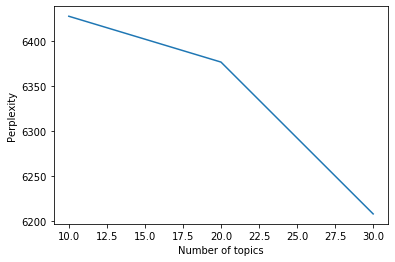

In [42]:
plt.plot(topics,perplexity_score)
plt.ylabel('Perplexity')
plt.xlabel('Number of topics')

In [168]:
# split data in train and test set

print(len(cleaned))
train_size = int(0.8*len(cleaned))

random.shuffle(cleaned)
train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

assert len(train_docs) + len(test_docs) == len(cleaned)

20494


In [36]:
def get_test_LL(test_docs, model):
    
    # make a list of documents of type required by tp
    test_set = []
    for doc in test_docs:
        test_set.append(model.make_doc(doc))
    
    # return topic distribution and log-likelihood of new documents
    topic_dist, likelihood = model.infer(test_set)
    
    # use mean log-likelihood as performance measure
    return np.mean(likelihood)

In [172]:
# loop for maximizing mean likelihood of test set

topics = [10,20,30]
log_likelihoods = np.array([])
for k in topics:
    print("Training for "+str(k)+" topics")
    model, LLs, time = train_LDA(train_docs, k = k, train_updates = 800)
    log_likelihoods = np.append(log_likelihoods, get_test_LL(test_docs, model))
    print("Log likelihood = "+str(get_test_LL(test_docs, model)))

topics[np.argmax(log_likelihoods)]

Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


30

In [ ]:
plt.plot(topics,log_likelihoods)
plt.ylabel('Likelihood')
plt.xlabel('Number of topics')

In [173]:
print(likelihoods)

[-882.05810779 -882.89588814 -879.71187388]


### Topic coherence 

---

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [28]:
num_topics = 10

In [ ]:
extract_word = lambda x: x[0] # get_topic_words returns both the word and its probability in the topic
topics = [[extract_word(tw) for tw in model.get_topic_words(k, 20)] for k in range(1,num_topics)]

In [59]:
topics[0]

['infect',
 'strain',
 'bacteria',
 'host',
 'resist',
 'bacteri',
 'pathogen',
 'cell',
 'use',
 'viru',
 'vaccin',
 'isol',
 'antibiot',
 'product',
 'iron',
 'viral',
 'microbiota',
 'specif',
 'diseas',
 'phage']

In [37]:
from gensim.corpora import Dictionary

In [39]:
dictionary = Dictionary(cleaned)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in cleaned] # bag of words corpus 

In [66]:
BoW_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1)]

In [38]:
# saving the coherence preprocessing operations into two functions
extract_word = lambda x: x[0] # get_topic_words returns both the word and its probability in the topic

def get_topics(model, num_topics):
    return [[extract_word(tw) for tw in model.get_topic_words(k, 20)] for k in range(1,num_topics)]

def get_corpus(dictionary, texts):
    return [dictionary.doc2bow(doc, allow_update=True) for doc in texts]

In [70]:
# topics (list of list of str, optional) – List of tokenized topics
# texts (list of list of str, optional) – Tokenized texts, needed for coherence models that use sliding window based (i.e. coherence=`c_something`) probability estimator .
# corpus (iterable of list of (int, number), optional) – Corpus in BoW format.
# dictionary (Dictionary, optional) – Gensim dictionary mapping of id word to create corpus. If model.id2word is present, this is not needed. If both are provided, passed dictionary will be used.
# window_size (int, optional) – Is the size of the window to be used for coherence measures using boolean sliding window as their probability estimator. For ‘u_mass’ this doesn’t matter. If None - the default window sizes are used which are: ‘c_v’ - 110, ‘c_uci’ - 10, ‘c_npmi’ - 10.
# coherence ({'u_mass', 'c_v', 'c_uci', 'c_npmi'}, optional) – Coherence measure to be used. Fastest method - ‘u_mass’, ‘c_uci’ also known as c_pmi. For ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary. For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
# topn (int, optional) – Integer corresponding to the number of top words to be extracted from each topic.
cm = CoherenceModel(topics=topics, corpus=BoW_corpus, dictionary=dictionary, texts=cleaned, coherence='c_v')
coherence = cm.get_coherence()  # get coherence value
coherence

0.49646788489478966

In [ ]:
# Note: there are different types of coherence measures, we need to decide which to use!

###  Complete grid search 

---

In [39]:
random.seed = 11

In [40]:
# split data in train, test and validation set
print(len(cleaned))
train_size = int(0.6*len(cleaned)) #60% for training
test_size = int(0.2*len(cleaned)) #20% for testing and 10% for validating

random.shuffle(cleaned)

train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:train_size+test_size]
val_docs = cleaned[train_size+test_size:]

len(train_docs) + len(test_docs) + len(val_docs) == len(cleaned)

20494


True

In [ ]:
# Grid search of best topic number (this needs to run for a while)
# We collect LL, perplexity and coherence scores, saving them in variables 

import time


dictionary = Dictionary(cleaned) # this we need later for gensim 
ks = [10,20,30,50,70,100,1000] # we have 16k documents, how many topics should we identify?
log_likelihoods = []
perplexities = []
coherences = []
for k in ks:
    
    start = time.time()
    
    print("Training for "+str(k)+" topics -----------------------------")
    model, LLs, _ = train_LDA(train_docs, k, min_cf=0, 
                                 min_df=0, rm_top=0, alpha=0.1, 
                                 eta=0.01, model_burn_in=100, 
                                 train_updates = 500, train_iter = 10)
    
    # LL
    log_likelihoods += [get_test_LL(test_docs, model)]
    print("Log likelihood = "+str(get_test_LL(test_docs, model)))
    
    ## PP
    # TODO: obtain perplexity on the test set
    perplexities += [model.perplexity]
    print("Perplexity = "+str(model.perplexity))
    
    ## CHR
    topics = get_topics(model, k)
    corpus = get_corpus(dictionary, test_docs)
    cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, texts=train_docs, coherence='u_mass')
    coherence = cm.get_coherence()  # get coherence value
    coherences += [coherence]
    print("Coherence = "+str(coherence))
    
    
    end = time.time()
    
    print("Time elapsed: "+ str(round(end - start,1))+" s")

Training for 10 topics -----------------------------


Training...


Num docs: 12296 , Vocab size: 56507 , Num words: 1282721
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Log likelihood = -879.3397307918385
Perplexity = 6832.771771754188
Coherence = -1.9234681155732096
Time elapsed: 63.8 s
Training for 20 topics -----------------------------


Training...


Num docs: 12296 , Vocab size: 56507 , Num words: 1282721
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Log likelihood = -883.6947845289072
Perplexity = 6884.56302076371
Coherence = -2.3103442700798644
Time elapsed: 104.3 s
Training for 30 topics -----------------------------


Training...


Num docs: 12296 , Vocab size: 56507 , Num words: 1282721
Removed top words: []


In [ ]:
# plotting the results
fig, axs = plt.subplots(1, 3)
axs[0].plot(topics,log_likelihoods)
axs[1].plot(topics,perplexities)
axs[2].plot(topics,coherences)
axs[0].set_title("Test log-likelihood")
axs[1].set_title("Train perplexity")
axs[2].set_title("Train coherence")

In [ ]:
# evaluate the model on the validation set 

#### Nice visualisation 

--- 

In [36]:
#!pip3.7 install pyLDAvis

In [44]:
import pyLDAvis
pyLDAvis.enable_notebook()

**Note**: you need to have trained a model to use the following code 

In [45]:
topic_term_dists = np.stack([model.get_topic_word_dist(k) for k in range(model.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in model.docs])
doc_lengths = np.array([len(doc.words) for doc in model.docs])
vocab = list(model.used_vocabs)
term_frequency = model.used_vocab_freq

In [ ]:
# doesn't work ...
pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency)

## Next up

- experimenting with CTM
- experimenting with Pachinko